# Data Analysis 
I will be using this notebook to analyse the data I have recorded, find correllations, and see if my assumptions about the data are correct or not. I would also like to acknowledge here that the process of recording the data was not perfect as the F125's violation system can be inconsistent at times. Another thing to mention is that the region where a driver brakes or hits the throttle are not the only factors that can cause them to crash or violate the track limits, there can be other reasons like the position of their steering, wheel, track conditions, etc. that are not in the scope of this project.

## Assumptions
My assumptions are as follows:

- I believe that the time between the moment a driver hits the brakes and hits the throttle is correllated to the overall lap time. My reasoning is that if the time difference between those inputs is too high, the car is slower for longer.
- I think that the number of times a car brakes is also correllated to the overall lap time. I think this is because the car is slowing down at another point in the lap which may be unneccessary if the driver takes a better racing line with lesser number of braking needed but this may be wrong as sometimes slowing down to take a turn and hitting the apex can be better than forcing the car to turn at a higher speed and missing the apex.
-  

## Exploring the data 
In the code chunk below I have imported all the libraries I require for the data analysis and have loaded the data as well.

In [28]:
# FIRST EDITED: 14/02/2026

import csv
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../Data/collated-data/lap-image-association.csv")

# in the arrays below, s1 means sector 1
s1_num = df["lap_num"].to_numpy()
s1_times = df["s1_time"].to_numpy()
s1_incident = df["incident"].to_numpy()
s1_b_t_deltas = df["brake_throttle_deltas"].to_numpy()
s1_brake_hits = df["related_b_hits"].to_numpy()
s1_throttle_hits = df["related_t_hits"].to_numpy()
#print(df.head)

# LAST EDITED: 14/02/2026

In the code chunk below, I will some plot data.

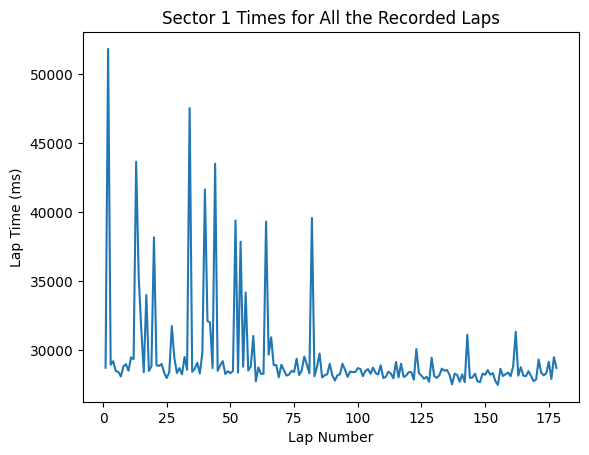

Total laps of data recorded: 178


In [29]:
# FIRST EDITED: 14/02/2026

plt.plot(s1_num, s1_times)
plt.title("Sector 1 Times for All the Recorded Laps")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

plt.show()

print(f"Total laps of data recorded: {s1_num[-1]}")

# LAST EDITED: 16/02/2026

There seem to be some laps that have very high sector-1 times and that is most probably due to a crash or track limit violation. These incidents result in the car having to get back to the track which takes a while (it should be noted that when I record this data the car is made indestructible to avoid repairs and ensure that all laps have the exact same car). In the code chunk below I will create a data frame without these incidents.

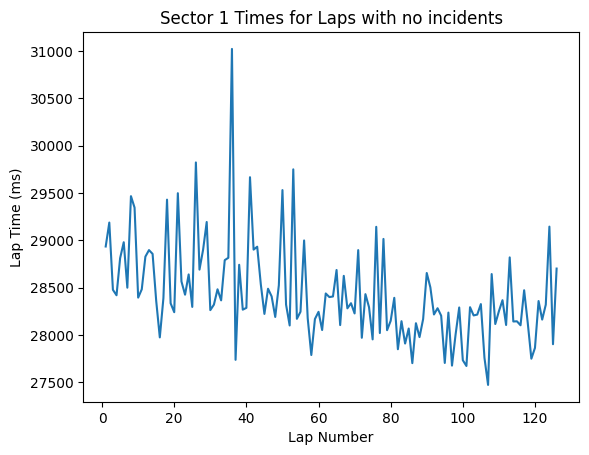

In [30]:
# FIRST EDITED: 14/02/2026

clean_df = df[df['incident'] == 'none']
clean_s1_times = clean_df["s1_time"].to_numpy()

#print(clean_df.head)

# Since the actual lap numbers may create the illusion that the number of laps
# without an incident are the same as the laps with an incident, I am going to use
# a simple range on the y-axis

pseudo_lap_num = np.arange(1, clean_s1_times.shape[0] + 1)

plt.plot(pseudo_lap_num, clean_s1_times)
plt.title("Sector 1 Times for Laps with no incidents")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

plt.show()
#print(clean_s1_times)

# LAST EDITED: 14/02/2026

Perhaps I should exclude laps with a sector-1 time higher than 30000ms. Another thing of note here is that I have improved at driving around the first sector of the lap after 100s of laps which might be why the later laps quicker. In the next code chunk I will remove laps with an unusually long secto-1 time (> 30000ms) and create arrays for the rest of the columns for later use.

Total number of laps recorded without any incident: 122


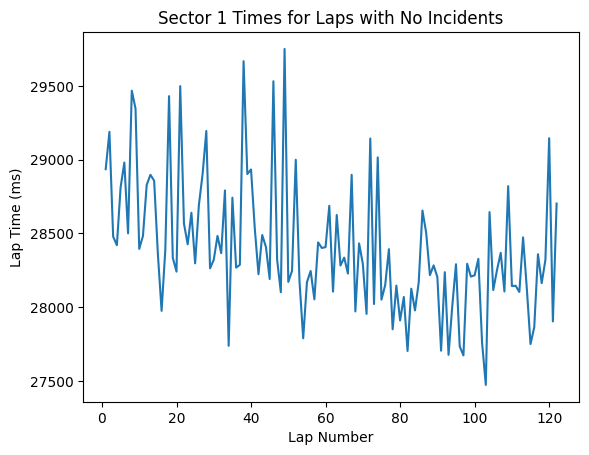

In [ ]:
# FIRST EDITED: 14/02/2026

clean_df = clean_df[clean_df['s1_time'] < 30000]

# Convert string to actual list
clean_df["related_b_hits"] = clean_df["related_b_hits"].apply(ast.literal_eval)
clean_df["related_t_hits"] = clean_df["related_t_hits"].apply(ast.literal_eval)

# Get rid of laps that have more than or less than two screenshots for throttles for incident-less laps
clean_df = clean_df[
    (clean_df["related_b_hits"].apply(len) == 2) &
    (clean_df["related_t_hits"].apply(len) == 2)
]

clean_s1_num = clean_df["lap_num"].to_numpy()
clean_s1_times = clean_df["s1_time"].to_numpy()
#clean_s1_b_t_deltas = clean_df["brake_throttle_deltas"].to_numpy()
clean_s1_brake_hits = clean_df["related_b_hits"].to_numpy()
clean_s1_throttle_hits = clean_df["related_t_hits"].to_numpy()

pseudo_lap_num = np.arange(1, clean_s1_times.shape[0] + 1)

plt.plot(pseudo_lap_num, clean_s1_times)
plt.title("Sector 1 Times for Laps with No Incidents")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")


print(f"Total number of laps recorded without any incident: {len(pseudo_lap_num)}")
# LAST EDITED: 21/02/2026

Now, without the outlier being present, my assumption about the lap times getting lower as I record more data seems more likely. I may need to find a way to account for this improvement. 

There can be no laps less than with more than two or less than two brakes or throttle since the sector-1 time would suffer a lot with an additional input and that lap time would be an outlier. I also discovered recently that certain throttle hits are not recorded using my script so this also filters those incorrect laps out.

There should be no laps with more than two brakes or two throttle hits, my assumption about sector-1 having more braking points seems incorrect. This finding will help us extract the break-throttle deltas as now I know that there are always going to be two time periods recorded. I will create two separate lists for the brake throttle deltas, one for turn 1 and the other for turn 3. Since the brake-throttle delta data does not exist for the earlier laps (because I had not originally planned to record that data), I will write the code to extract its data separately below since it requires a bit more nuance compared to brake and throttle hits.

In [42]:
# FIRST EDITED: 14/02/2026

t1_b_t_delta = []
t3_b_t_delta = []

for val in clean_df["brake_throttle_deltas"]:
    
    # Convert string to actual list
    parsed = ast.literal_eval(val)
    
    if parsed == []:
        t1_b_t_delta.append(0)
        t3_b_t_delta.append(0)
    else:
        # First element of each sublist is the time delta
        t1_b_t_delta.append(parsed[0][0])
        t3_b_t_delta.append(parsed[1][0])


# LAST EDITED: 21/02/2026

Now that this is done I will make some plots to spot any patterns in the code chunk below:

Text(0, 0.5, 'Time b/w Break and Throttle Hit')

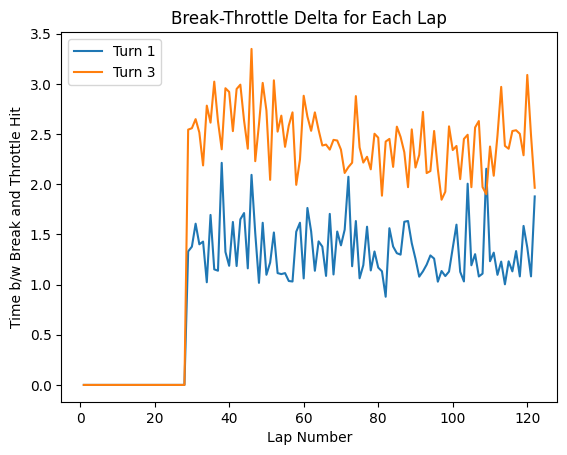

In [ ]:
# FIRST EDITED: 21/02/2026

plt.plot(pseudo_lap_num, t1_b_t_delta, label = "Turn 1")
plt.plot(pseudo_lap_num, t3_b_t_delta, label = "Turn 3")
plt.legend(loc = "upper left")
plt.title("Break-Throttle Delta for Each Lap")
plt.xlabel("Lap Number")
plt.ylabel("Time b/w Break and Throttle Hit (s)")

# LAST EDITED: 21/02/2026

Its interesting that even though my performance has improved over time in terms of sector-1 lap times, the amount of time between my brake and throttle hits has remained consistent. This could mean that my steering wheel inputs have improved. 

I will now create some plots to see if there is a corellation between low braking times and low sector-1 times.

Text(0, 0.5, 'Time b/w Break and Throttle Hit (s)')

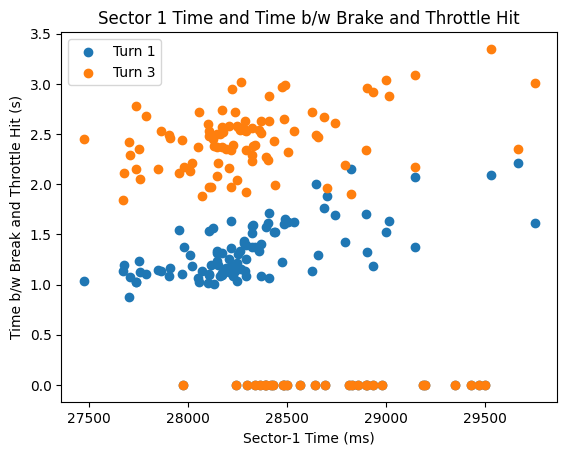

In [ ]:
# FIRST EDITED: 21/02/2026

plt.scatter(clean_s1_times, t1_b_t_delta, label = "Turn 1")
plt.scatter(clean_s1_times, t3_b_t_delta, label = "Turn 3")
plt.legend(loc = "upper left")
plt.title("Sector 1 Time and Time b/w Brake and Throttle Hit")
plt.xlabel("Sector-1 Time (ms)")
plt.ylabel("Time b/w Break and Throttle Hit (s)")


# TODO: Exclude 0 b-t deltas

# LAST EDITED: 21/02/2026